In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import OneHotEncoder, LabelEncoder, MinMaxScaler
from sklearn.model_selection import train_test_split
from pandas_profiling import ProfileReport

In [57]:
#Read Training and Testing Data
train = pd.read_csv('../input/customerattritionprediction/train.csv', index_col = 'ID')
test = pd.read_csv('../input/customerattritionprediction/test.csv', index_col = 'ID')
train.head()

,sex,Aged,Married,TotalDependents,ServiceSpan,MobileService,4GService,CyberProtection,HardwareSupport,TechnicalAssistance,FilmSubscription,SettlementProcess,QuarterlyPayment,GrandPayment,CustomerAttrition
ID,,,,,,,,,,,,,,,
B60LHTZLLPFU4IULNPUF,Female,No,No,Yes,48,Yes,Wifi Broadband,No,Yes,Yes,No,Check,96.259802,4628.129119,Yes
1RUJ7ONYZHYTWKOKO1SD,Male,No,Yes,No,45,Yes,Wifi Broadband,No,No,No,Yes,Bank,18.876470,922.085998,No
DZ9EEOQWSN0MYCBUPAM5,Male,Yes,Yes,No,59,Yes,Wifi Broadband,Yes,No,Yes,No,Card,106.016057,6205.891129,Yes
YZ43L1UQUQACTL1PXXZG,Male,No,No,No,14,Yes,Wifi Broadband,No,No,No,No,Check,80.108839,1248.655391,No
6P28152QGF60PDLSCB9M,Female,No,Yes,Yes,25,Yes,Wifi Broadband,No,Yes,No,Yes,Check,51.529773,1285.321277,No


# Basic Data Profile

In [3]:
profile = ProfileReport(train, title="Test Data Profiling Report")
profile.to_file("data_report.html")
profile

Summarize dataset:   0%|          | 0/29 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

Export report to file:   0%|          | 0/1 [00:00<?, ?it/s]

In [58]:
#Replace the only N/A value with the column's average 
test['GrandPayment'].fillna(value=test['GrandPayment'].mean(), inplace=True)

In [59]:
#Remove the N/A rows in the training data
print('BEFORE:', len(train.index))
print('NO. OF NULL VALUES:', len(train[train.isnull().any(axis = 1)].index))
train = train.dropna()
print('AFTER:', len(train.index))

BEFORE: 6338
NO. OF NULL VALUES: 10
AFTER: 6328


In [60]:
#All features
features = train.columns[:len(train.columns) - 1]

#Continous features
cont_features = ['ServiceSpan','QuarterlyPayment', 'GrandPayment']

#Feature to be predicted
prediction = train.columns[len(train.columns) - 1]

#Train Set with positive attrition
pos_train = train[train[prediction] == 'Yes']

X = train.drop(labels = prediction, axis = 1)
y = train[prediction]

#Categorical features
cat_features = X.columns[X.dtypes == object].tolist()

# Visualize Continous Features
Upon KDE plot generation, it is clear that there are some intervals of continous features where the kernel density is high for positive data which however is not translated for the over all data.

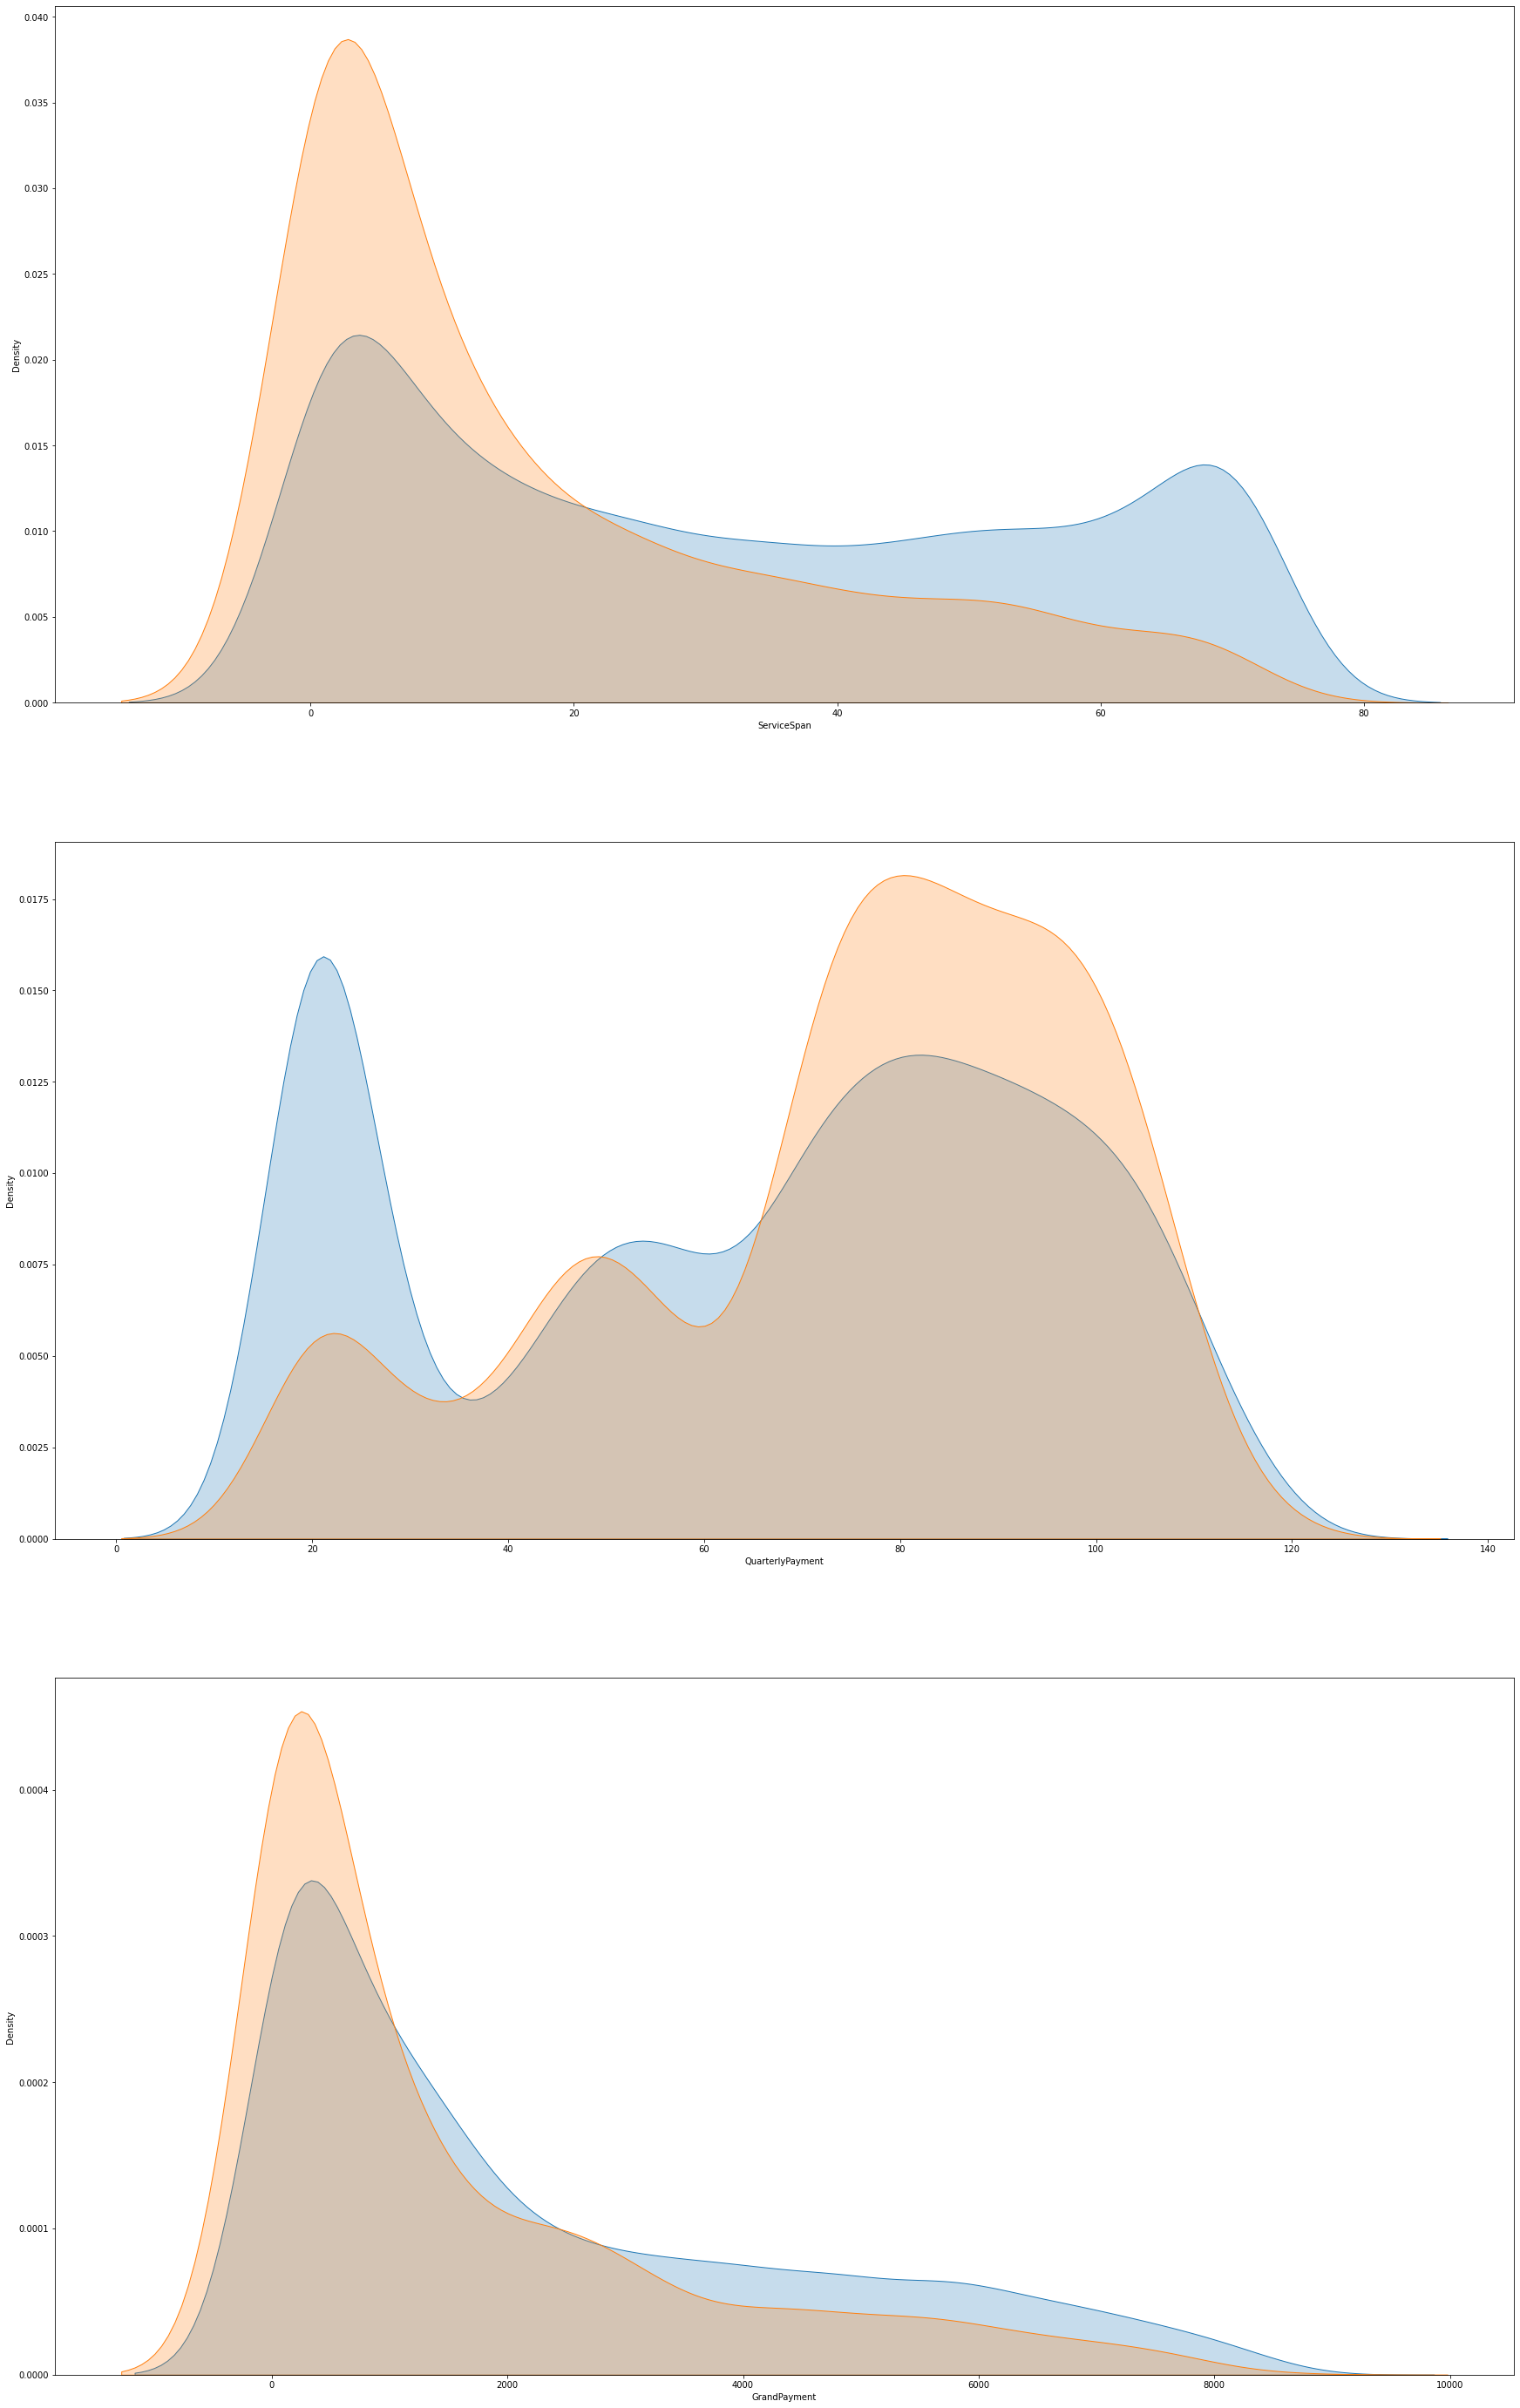

In [61]:
fig, ax = plt.subplots(len(cont_features), 1, figsize=(30, 50))

for (i,feature) in enumerate(cont_features):
    sns.kdeplot(data=train,  x=feature, ax=ax[i], shade=True, hue_order=prediction)
    sns.kdeplot(data=pos_train,  x=feature, ax=ax[i], shade=True, hue_order=prediction)
plt.show()

In [62]:
# X['NumSubscription']= X.apply(lambda x: 
#                                              (x['CyberProtection'] == "Yes") + 
#                                              (x['HardwareSupport'] == "Yes") + 
#                                              (x['TechnicalAssistance'] == "Yes") +
#                                              (x['FilmSubscription'] == "Yes"), axis=1)

# test['NumSubsription']= test.apply(lambda x: 
#                                              (x['CyberProtection'] == "Yes") + 
#                                              (x['HardwareSupport'] == "Yes") + 
#                                              (x['TechnicalAssistance'] == "Yes") +
#                                              (x['FilmSubscription'] == "Yes"), axis=1)

Create categorical bins for *quaterly payment* and *service span* features to bring out it's features more

In [63]:
range_labels = ['low', 'mid', 'high']
qp_bins = [0, 40, 60, 140]
sp_bins = [-2, 20, 60, 73]

X['QuarterlyPaymentRange'] = pd.cut(X['QuarterlyPayment'], bins=qp_bins, labels=range_labels)
test['QuarterlyPaymentRange'] = pd.cut(test['QuarterlyPayment'], bins=qp_bins, labels=range_labels)

X['ServiceSpanRange'] = pd.cut(X['ServiceSpan'], bins=sp_bins, labels=range_labels)
test['ServiceSpanRange'] = pd.cut(test['ServiceSpan'], bins=sp_bins, labels=range_labels)

cat_features.append('QuarterlyPaymentRange')
cat_features.append('ServiceSpanRange')

# Encode Data

In [64]:
#For categorical values
le = LabelEncoder()
y = le.fit_transform(y)

for cat_f in cat_features:
    #combine the train and test sets
    tot = X[cat_f].append(test[cat_f])
    le.fit(tot)
    X[cat_f] = le.transform(X[cat_f])
    test[cat_f] = le.transform(test[cat_f])

In [65]:
#For continous values
mm_scaler = MinMaxScaler()

tot = X[cont_features].append(test[cont_features])
mm_scaler.fit(tot)
X[cont_features] = mm_scaler.transform(X[cont_features])
test[cont_features] = mm_scaler.transform(test[cont_features])

In [66]:
#Display the final training dataset
X

,sex,Aged,Married,TotalDependents,ServiceSpan,MobileService,4GService,CyberProtection,HardwareSupport,TechnicalAssistance,FilmSubscription,SettlementProcess,QuarterlyPayment,GrandPayment,QuarterlyPaymentRange,ServiceSpanRange
ID,,,,,,,,,,,,,,,,
B60LHTZLLPFU4IULNPUF,0,0,0,1,0.662162,1,2,0,1,1,0,2,0.769898,0.531957,0,2
1RUJ7ONYZHYTWKOKO1SD,1,0,1,0,0.621622,1,2,0,0,0,1,0,0.024856,0.104479,1,2
DZ9EEOQWSN0MYCBUPAM5,1,1,1,0,0.810811,1,2,1,0,1,0,1,0.863831,0.713946,0,2
YZ43L1UQUQACTL1PXXZG,1,0,0,0,0.202703,1,2,0,0,0,0,2,0.614398,0.142148,0,1
6P28152QGF60PDLSCB9M,0,0,1,1,0.351351,1,2,0,1,0,1,2,0.339240,0.146377,2,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Y7U717HO87PCW6XXIQA1,0,1,0,0,0.054054,1,2,0,1,0,1,1,0.809679,0.049093,0,1
NGY3WOQ0OT1P4RHAR0PT,0,1,0,0,0.000000,1,1,0,0,0,1,0,0.274275,0.003346,2,1
ZBBW7H8AYLZJ2HK5TBBJ,1,0,0,1,0.256757,1,0,0,0,0,0,3,0.189159,0.061812,1,1


# Sampling
As it is evident from the profile data, ther a class difference (more negative attrition are there than positive counterparts). Hence we oversample the data to create more positive data.

In [67]:
from imblearn.pipeline import Pipeline
from imblearn.over_sampling import RandomOverSampler, SMOTE, ADASYN
from imblearn.under_sampling import RandomUnderSampler

# define resampling
over = RandomOverSampler(sampling_strategy=0.98) #This is essentially oversampling the data
under = RandomUnderSampler(sampling_strategy=1)

# define pipeline for oversampling and undersampling
pipeline = Pipeline(steps=[('o', over), ('u', under)])

X_sampled, y_sampled = pipeline.fit_resample(X, y)

# View the Class Distribution before and after Sampling

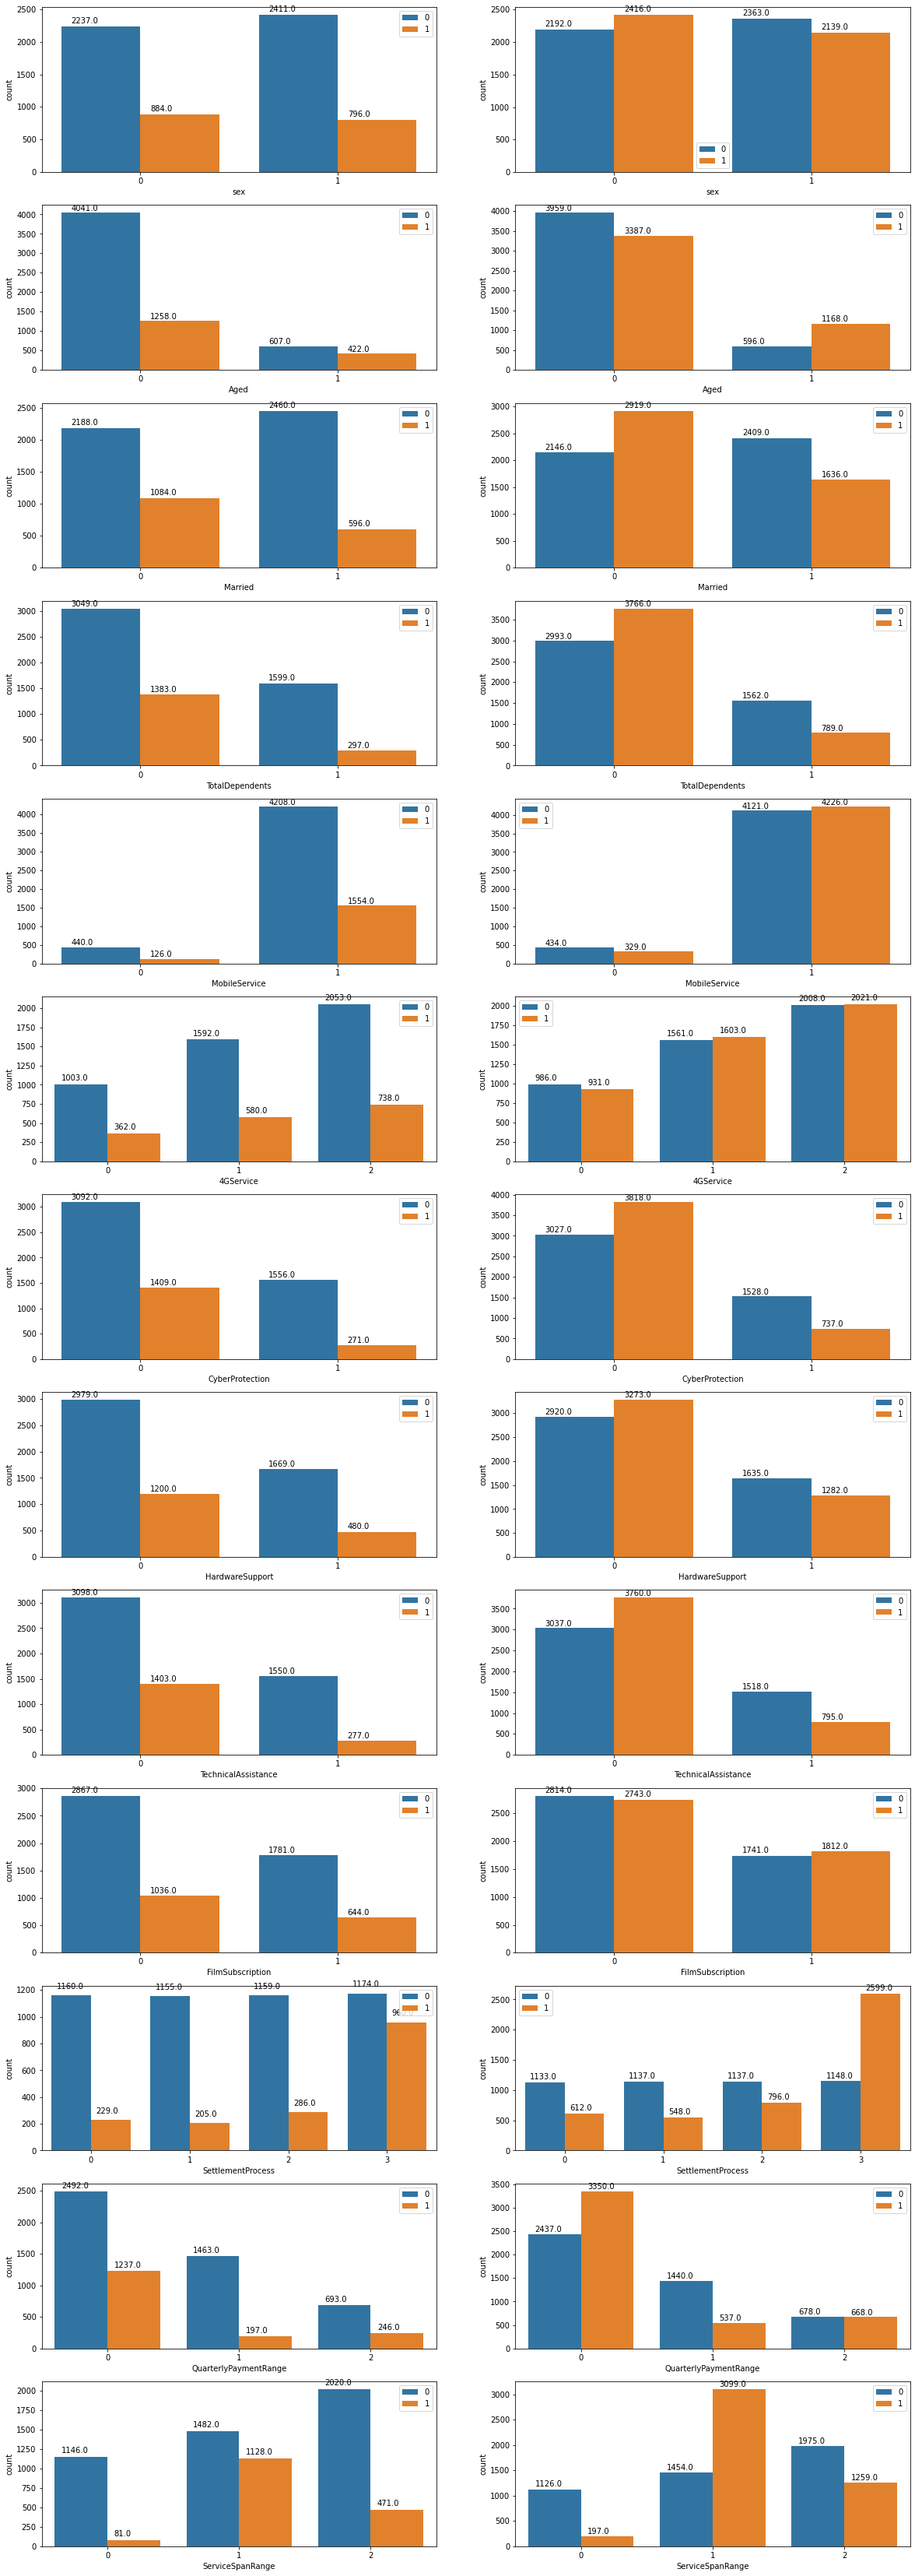

In [68]:
fig, ax = plt.subplots(len(cat_features), 2, figsize=(20, 60))

for (i,feature) in enumerate(cat_features):
    
    #Before Resampling
    sns.countplot(x=feature, hue=y, ax=ax[i][0], data=X)
    
    #After Resampling
    sns.countplot(x=feature, hue=y_sampled, ax=ax[i][1], data=X_sampled)
    
    for p in ax[i][1].patches:
        ax[i][1].annotate('{:.1f}'.format(p.get_height()), (p.get_x()+0.05, p.get_height()+50))
        
    for p in ax[i][0].patches:
        ax[i][0].annotate('{:.1f}'.format(p.get_height()), (p.get_x()+0.05, p.get_height()+50))

In [81]:
from sklearn.metrics import confusion_matrix, accuracy_score, recall_score, precision_score, f1_score, classification_report
from sklearn.model_selection import cross_val_score, cross_val_predict
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.model_selection import GridSearchCV

#RepeatedStratified KFold Cross Validation for various probability grouping based on the argument proba 
def eval_model(model, proba = 0.5):
    cv_rep = RepeatedStratifiedKFold(n_splits=5, n_repeats=2, random_state=1)
    count = 0
    
    avg_accuracy = 0
    avg_recall = 0
    avg_precision = 0
    avg_f1_score = 0
    
    print("Total Splits:", cv_rep.get_n_splits())
    
    for train_index, test_index in cv_rep.split(X_sampled, y_sampled):
        
        print('KFold {}/{}'.format(count+1,cv_rep.get_n_splits()))
        X_cv_train, y_cv_train = X_sampled.loc[train_index], y_sampled[train_index]
        X_cv_test, y_cv_test = X_sampled.loc[test_index], y_sampled[test_index]
        
        model.fit(X_cv_train,y_cv_train)
        y_pred_test = np.where(model.predict_proba(X_cv_test)[:,1] >= proba, 1, 0 )
        avg_accuracy += accuracy_score(y_cv_test, y_pred_test)
        avg_recall += recall_score(y_cv_test, y_pred_test, average=None)
        avg_precision += precision_score(y_cv_test, y_pred_test, average=None)
        avg_f1_score += f1_score(y_cv_test, y_pred_test, average='weighted')
        
        print("Accuracy:", avg_accuracy/(count+1))
        print("Recall:", avg_recall/(count+1))
        print("Precision:", avg_precision/(count+1))
        print("f1-score:", avg_f1_score/(count+1))    
        
#         cm = confusion_matrix(y_cv_train, y_pred_train)
#         plt.imshow(cm, cmap='binary')

        count += 1
        
    print("\nTest Set Classification Report")
    print("Accuracy:", avg_accuracy/cv_rep.get_n_splits())
    print("Recall:", avg_recall/cv_rep.get_n_splits())
    print("Precision:", avg_precision/cv_rep.get_n_splits())
    print("f1-score:", avg_f1_score/cv_rep.get_n_splits())    
    

#Used to fine tune the model with the given parameters
def grid_search(model, parameters):
    grid_search = GridSearchCV(estimator = model, param_grid = parameters,scoring = 'accuracy',cv = 5, n_jobs=-1, verbose=5)
    grid_search = grid_search.fit(X_sampled, y_sampled)
    print(grid_search.best_params_)
    print(grid_search.best_score_)

# Fine Tune Basic Models with Hyperparameter Search
Most models perform about the same with different hyperparameters hence, the no fine tuning is done

In [78]:
from sklearn.ensemble import RandomForestClassifier
random = RandomForestClassifier()
parameters = [{
          'n_estimators' : [250,300],
          'criterion': ['entropy', 'gini'],
          'max_features': ['auto', 'log2']
          }]
# grid_search(random, parameters)
# eval_model(clf1)

In [85]:
from sklearn.ensemble import RandomForestClassifier
random = RandomForestClassifier()
eval_model(random, 0.65)

Total Splits: 10
KFold 1/10
Accuracy: 0.9028540065861691
Recall: [0.90889133 0.89681668]
Precision: [0.89804772 0.90777778]
f1-score: 0.9028504655582676
KFold 2/10
Accuracy: 0.9127332601536773
Recall: [0.91383095 0.91163557]
Precision: [0.91196634 0.91358388]
f1-score: 0.9127309184945815
KFold 3/10
Accuracy: 0.9149286498353458
Recall: [0.9140139 0.9158434]
Precision: [0.915812   0.91412838]
f1-score: 0.9149264325136407
KFold 4/10
Accuracy: 0.9152030735455544
Recall: [0.9154775  0.91492865]
Precision: [0.91507251 0.91540823]
f1-score: 0.9152011006776543
KFold 5/10
Accuracy: 0.914489571899012
Recall: [0.91328211 0.91569704]
Precision: [0.91557694 0.91349542]
f1-score: 0.9144870938594304
KFold 6/10
Accuracy: 0.9142883278448591
Recall: [0.91163557 0.91694109]
Precision: [0.91658287 0.91212526]
f1-score: 0.9142848520681794
KFold 7/10
Accuracy: 0.9153206837070723
Recall: [0.91312529 0.91751607]
Precision: [0.91722141 0.9135328 ]
f1-score: 0.9153177010924365
KFold 8/10
Accuracy: 0.91561470911

In [86]:
from imblearn.ensemble import BalancedRandomForestClassifier
brf = BalancedRandomForestClassifier()
eval_model(brf)

Total Splits: 10
KFold 1/10
Accuracy: 0.8754116355653129
Recall: [0.8090011  0.94182217]
Precision: [0.93291139 0.83139535]
f1-score: 0.874859721946129
KFold 2/10
Accuracy: 0.886663007683864
Recall: [0.81997805 0.95334797]
Precision: [0.94617686 0.8411575 ]
f1-score: 0.8861571667101742
KFold 3/10
Accuracy: 0.8915111598975486
Recall: [0.82583242 0.9571899 ]
Precision: [0.95070072 0.84606865]
f1-score: 0.8910399075074568
KFold 4/10
Accuracy: 0.8899560922063667
Recall: [0.82628979 0.95362239]
Precision: [0.94689651 0.8459196 ]
f1-score: 0.8895070954729047
KFold 5/10
Accuracy: 0.8903402854006586
Recall: [0.82612514 0.95455543]
Precision: [0.94789695 0.84592172]
f1-score: 0.8898852933152289
KFold 6/10
Accuracy: 0.8891328210757409
Recall: [0.82528357 0.95298207]
Precision: [0.94613802 0.84507149]
f1-score: 0.8886784270595429
KFold 7/10
Accuracy: 0.8901521091422299
Recall: [0.82578015 0.95452407]
Precision: [0.94784999 0.84565122]
f1-score: 0.8896947843718956
KFold 8/10
Accuracy: 0.8905735455

In [49]:
from sklearn.ensemble import ExtraTreesClassifier
etc = ExtraTreesClassifier()
eval_model(etc)

Total Splits: 10
KFold 1/10
Accuracy: 0.8929747530186608
Recall: [0.84083425 0.94511526]
Precision: [0.93872549 0.85586481]
f1-score: 0.8926829975542634
KFold 2/10
Accuracy: 0.8957189901207464
Recall: [0.84467618 0.9467618 ]
Precision: [0.94070421 0.85907013]
f1-score: 0.8954461532091051
KFold 3/10
Accuracy: 0.897914379802415
Recall: [0.85217709 0.94365166]
Precision: [0.93803736 0.86467923]
f1-score: 0.8976922585528863
KFold 4/10
Accuracy: 0.8976399560922064
Recall: [0.8518112  0.94346872]
Precision: [0.93780855 0.86433857]
f1-score: 0.8974184192427124
KFold 5/10
Accuracy: 0.8996706915477498
Recall: [0.85883644 0.94050494]
Precision: [0.93535566 0.8697638 ]
f1-score: 0.8994854369709093
KFold 6/10
Accuracy: 0.8966337358214417
Recall: [0.85638492 0.93688255]
Precision: [0.93149943 0.8672955 ]
f1-score: 0.8964517969219217
KFold 7/10
Accuracy: 0.8975223459306886
Recall: [0.85808374 0.93696095]
Precision: [0.9316828  0.86865282]
f1-score: 0.8973497859645363
KFold 8/10
Accuracy: 0.899080680

In [87]:
from sklearn.ensemble import StackingClassifier
from sklearn.linear_model import LogisticRegression
stack2 = StackingClassifier(estimators=[('randomforest', random), ('extratree', etc), ('bal_randomforest', brf)], final_estimator=LogisticRegression())
eval_model(stack2, 0.65)

Total Splits: 10
KFold 1/10
Accuracy: 0.9215148188803512
Recall: [0.95060373 0.89242591]
Precision: [0.89834025 0.94755245]
f1-score: 0.921448351234219
KFold 2/10
Accuracy: 0.9275521405049396
Recall: [0.94840834 0.90669594]
Precision: [0.91062623 0.94618613]
f1-score: 0.9275136144953782
KFold 3/10
Accuracy: 0.9313940724478594
Recall: [0.94840834 0.9143798 ]
Precision: [0.91742898 0.94659985]
f1-score: 0.9313666204007829
KFold 4/10
Accuracy: 0.9318057080131723
Recall: [0.94978046 0.91383095]
Precision: [0.91699692 0.9479224 ]
f1-score: 0.9317778342913775
KFold 5/10
Accuracy: 0.9306256860592755
Recall: [0.94862788 0.91262349]
Precision: [0.91580092 0.94672061]
f1-score: 0.9305985242526296
KFold 6/10
Accuracy: 0.93130259787779
Recall: [0.94731065 0.91529455]
Precision: [0.91808428 0.94560051]
f1-score: 0.9312795662570726
KFold 7/10
Accuracy: 0.9310804453504783
Recall: [0.94699702 0.91516387]
Precision: [0.9179198  0.94528256]
f1-score: 0.9310583332129659
KFold 8/10
Accuracy: 0.93166849615

# Exporting the Prediction

In [91]:
stack2.fit(X, y)
y_pred = np.where(stack2.predict_proba(test)[:,1] >= 0.48, 1, 0 )
y_pred

array([0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0,
       1, 1, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0,
       0, 1, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0,
       1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0,
       0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 1,
       0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0,
       0, 1, 0, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0,
       1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0,

In [98]:
y_pred = pd.DataFrame({'CustomerAttrition': y_pred})['CustomerAttrition'].map({1:'Yes', 0:'No'})

In [99]:
y_pred.value_counts()

No     561
Yes    144
Name: CustomerAttrition, dtype: int64

In [100]:
output = pd.DataFrame({'ID': test.index, 'CustomerAttrition': y_pred})
output.to_csv('multi-stacked-classifier.csv', index=False)